<a href="https://colab.research.google.com/github/ItbaMalahat/DataScienceAssignment3-/blob/main/2021250_a3_cs439.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PySpark
!pip install pyspark


In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
from google.colab import files

# Upload the Netflix dataset
uploaded = files.upload()


Saving netflix_titles.csv to netflix_titles (1).csv


In [4]:
# Start Spark session
spark = SparkSession.builder.appName("Netflix EDA").getOrCreate()

# Load dataset into a Spark DataFrame
df = spark.read.option("header", "true").csv("netflix_titles.csv")


In [5]:
# Display schema
df.printSchema()

# Display first few rows
df.show(5)


root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)

+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|       director|                cast|      country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+-------------------

In [6]:
# Count rows and columns
print(f"Total rows: {df.count()}")
print(f"Total columns: {len(df.columns)}")


Total rows: 8809
Total columns: 12


In [7]:
# Count missing values for each column
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|show_id|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|      0|   1|    2|    2636| 826|    832|        13|           2|     6|       5|        3|          3|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+



In [8]:
# Group by type and count
df.groupBy("type").count().show()


+-------------+-----+
|         type|count|
+-------------+-----+
|         NULL|    1|
|      TV Show| 2676|
|        Movie| 6131|
|William Wyler|    1|
+-------------+-----+



In [9]:
# Count the most common genres
from pyspark.sql.functions import explode, split

df.withColumn("genre", explode(split(col("listed_in"), ","))) \
  .groupBy("genre").count() \
  .orderBy("count", ascending=False).show()


+--------------------+-----+
|               genre|count|
+--------------------+-----+
| International Mo...| 2622|
|              Dramas| 1595|
|            Comedies| 1206|
|  Action & Adventure|  857|
|       Documentaries|  827|
|              Dramas|  824|
|International TV ...|  774|
|  Independent Movies|  731|
|           TV Dramas|  695|
|     Romantic Movies|  613|
|Children & Family...|  605|
| International TV...|  576|
|           Thrillers|  508|
|            Comedies|  464|
|         TV Comedies|  461|
|      Crime TV Shows|  398|
|            Kids' TV|  388|
|    Music & Musicals|  355|
|   Romantic TV Shows|  338|
|     Stand-Up Comedy|  334|
+--------------------+-----+
only showing top 20 rows



In [10]:
# Count content per release year
df.groupBy("release_year").count().orderBy("release_year").show()





+-----------------+-----+
|     release_year|count|
+-----------------+-----+
|             NULL|    2|
|   Charles Rocket|    1|
|          Dr. Dre|    1|
|   Francis Weddey|    1|
|     Imanol Arias|    1|
|      Jade Eshete|    1|
| Kristen Johnston|    1|
| Marquell Manning|    1|
|       Nick Kroll|    1|
|    Nse Ikpe-Etim|    1|
|       Paul Sambo|    1|
|   Peter Ferriero|    1|
|     Ted Ferguson|    1|
| Álvaro Cervantes|    1|
|             1925|    1|
|             1942|    2|
|             1943|    3|
|             1944|    2|
|             1945|    4|
|             1946|    2|
+-----------------+-----+
only showing top 20 rows



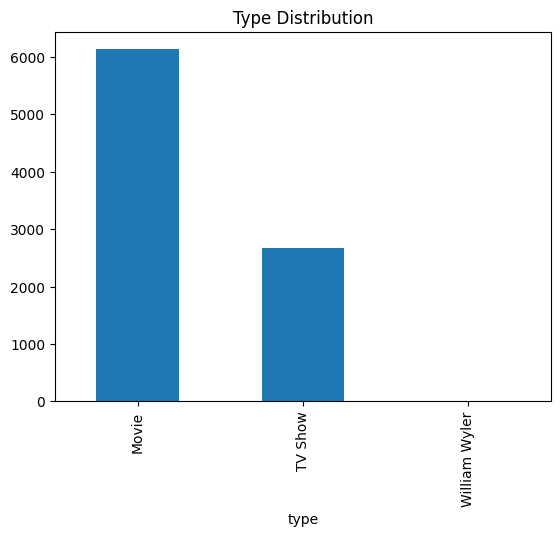

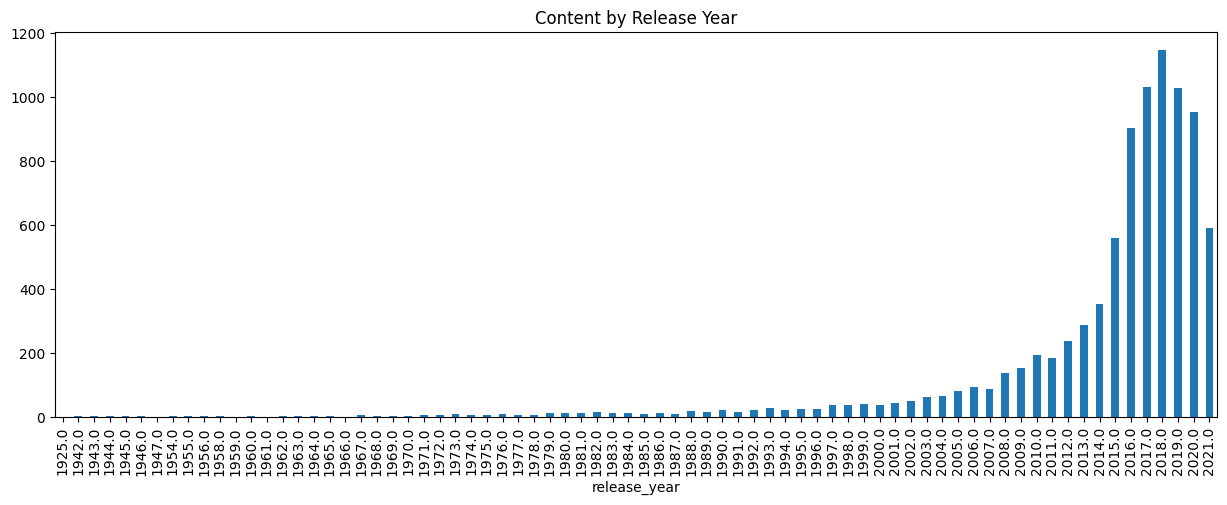

In [11]:
# Convert Spark DataFrame to Pandas
pandas_df = df.toPandas()

# Plot type distribution
pandas_df['type'].value_counts().plot(kind='bar', title='Type Distribution')
plt.show()

# Plot release year distribution
pandas_df['release_year'] = pd.to_numeric(pandas_df['release_year'], errors='coerce')
pandas_df['release_year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5), title='Content by Release Year')
plt.show()


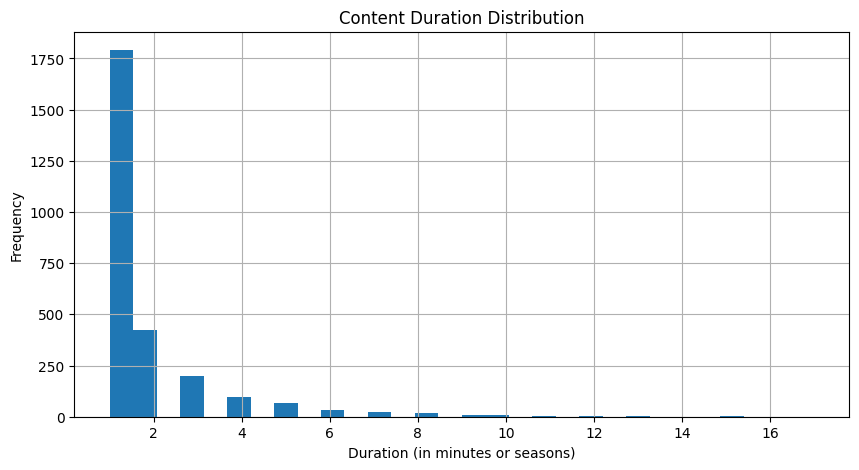

In [13]:
# Updated function to handle various cases
def extract_duration(duration):
    try:
        if 'h' in duration and 'm' in duration:  # Movies in hours and minutes
            parts = duration.replace('h', '').replace('m', '').split()
            hours = int(parts[0]) * 60  # Convert hours to minutes
            minutes = int(parts[1]) if len(parts) > 1 else 0
            return hours + minutes
        elif 'h' in duration:  # Movies in hours only
            hours = int(duration.replace('h', ''))
            return hours * 60
        elif 'm' in duration:  # Movies in minutes only
            minutes = int(duration.replace('m', ''))
            return minutes
        elif 'Season' in duration:  # TV Shows in seasons
            return int(duration.split()[0])
        else:  # Unknown format
            return np.nan
    except Exception as e:
        return np.nan  # Handle unexpected errors gracefully

# Apply the updated function
pandas_df['duration_num'] = pandas_df['duration'].apply(lambda x: extract_duration(x) if pd.notnull(x) else np.nan)

# Plot the distribution of duration
pandas_df['duration_num'].dropna().hist(bins=30, figsize=(10, 5))
plt.title('Content Duration Distribution')
plt.xlabel('Duration (in minutes or seasons)')
plt.ylabel('Frequency')
plt.show()


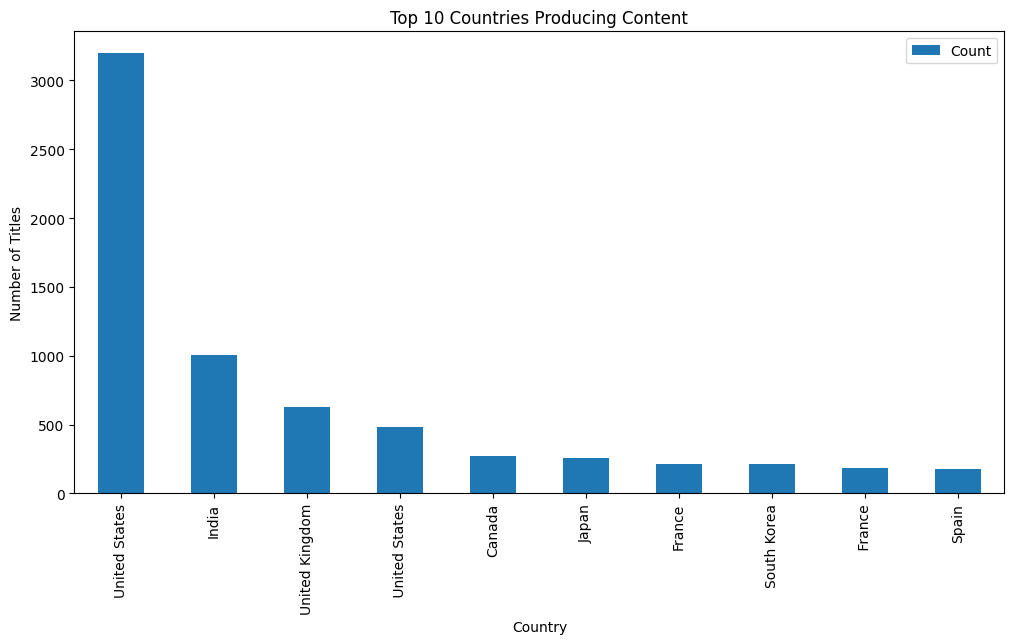

In [14]:
# Split and count countries
from collections import Counter

countries = pandas_df['country'].dropna().str.split(',').sum()
country_counts = Counter(countries)

# Plot top 10 countries
pd.DataFrame(country_counts.most_common(10), columns=['Country', 'Count']).set_index('Country').plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Countries Producing Content')
plt.xlabel('Country')
plt.ylabel('Number of Titles')
plt.show()


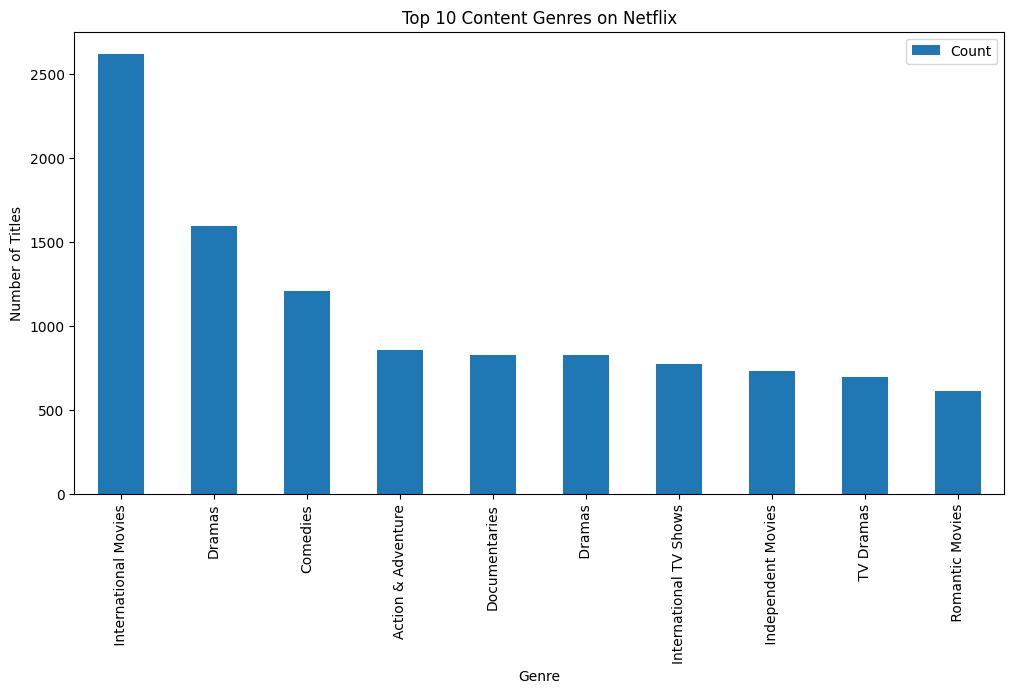

In [15]:
# Split genres and count
genres = pandas_df['listed_in'].dropna().str.split(',').sum()
genre_counts = Counter(genres)

# Plot top 10 genres
pd.DataFrame(genre_counts.most_common(10), columns=['Genre', 'Count']).set_index('Genre').plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Content Genres on Netflix')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.show()


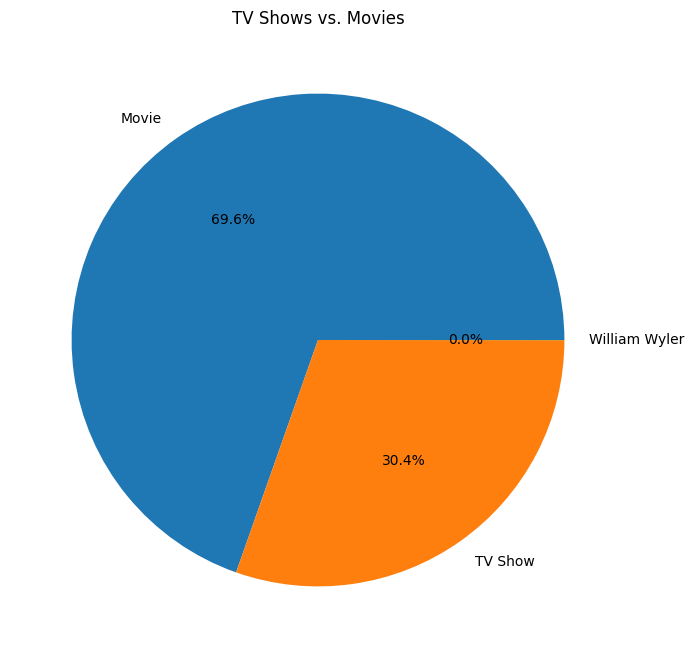

In [16]:
# Plot pie chart
pandas_df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('TV Shows vs. Movies')
plt.ylabel('')
plt.show()


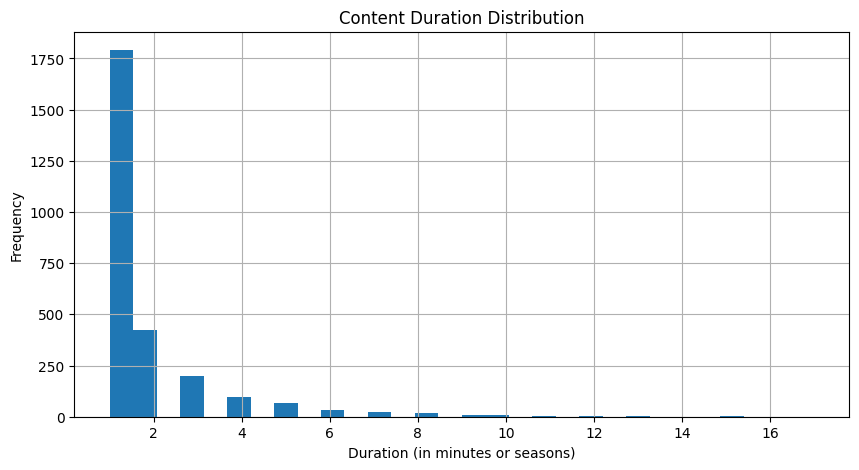

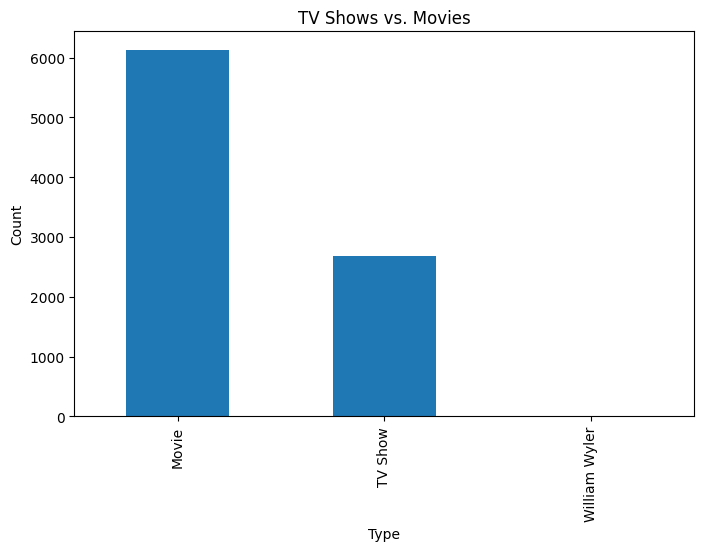

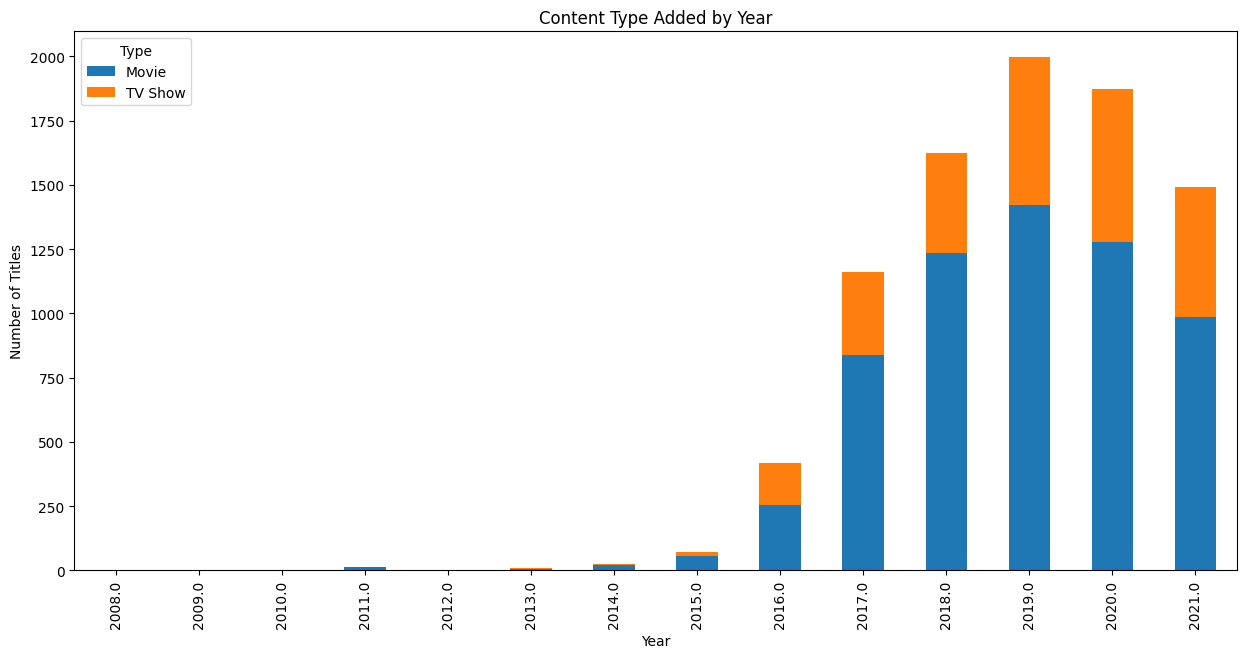

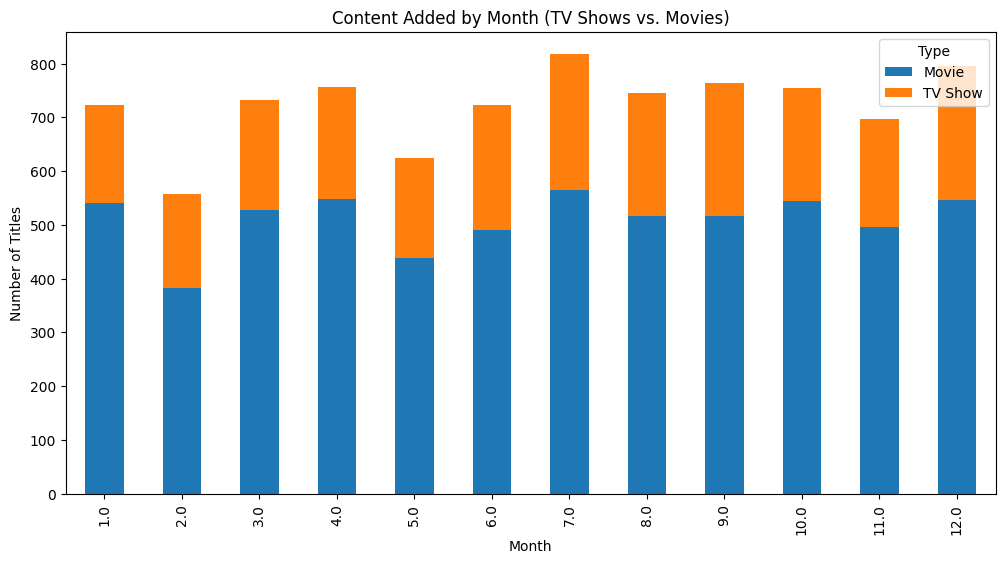

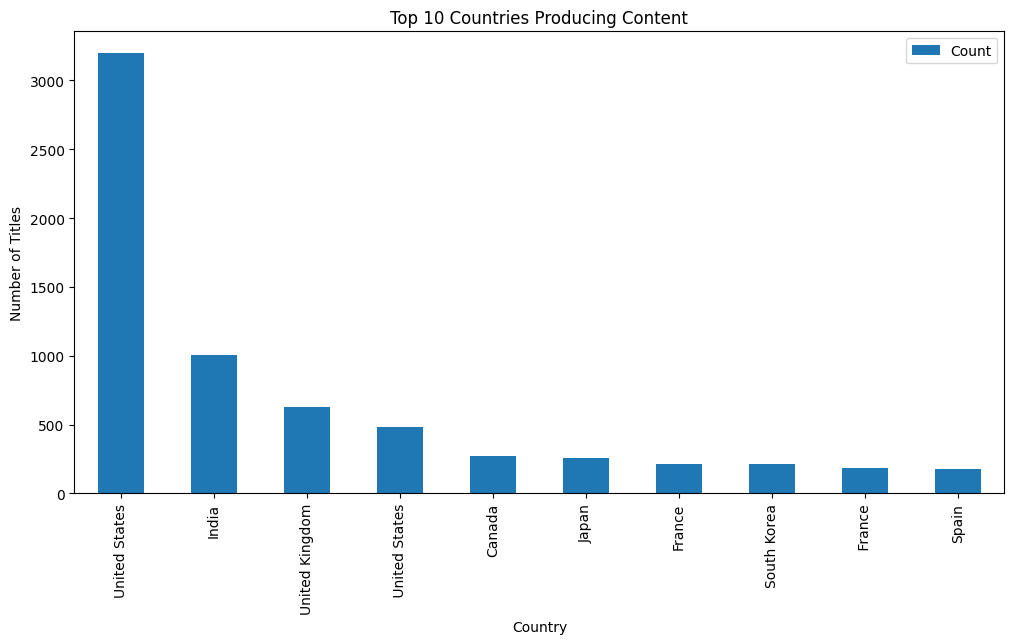

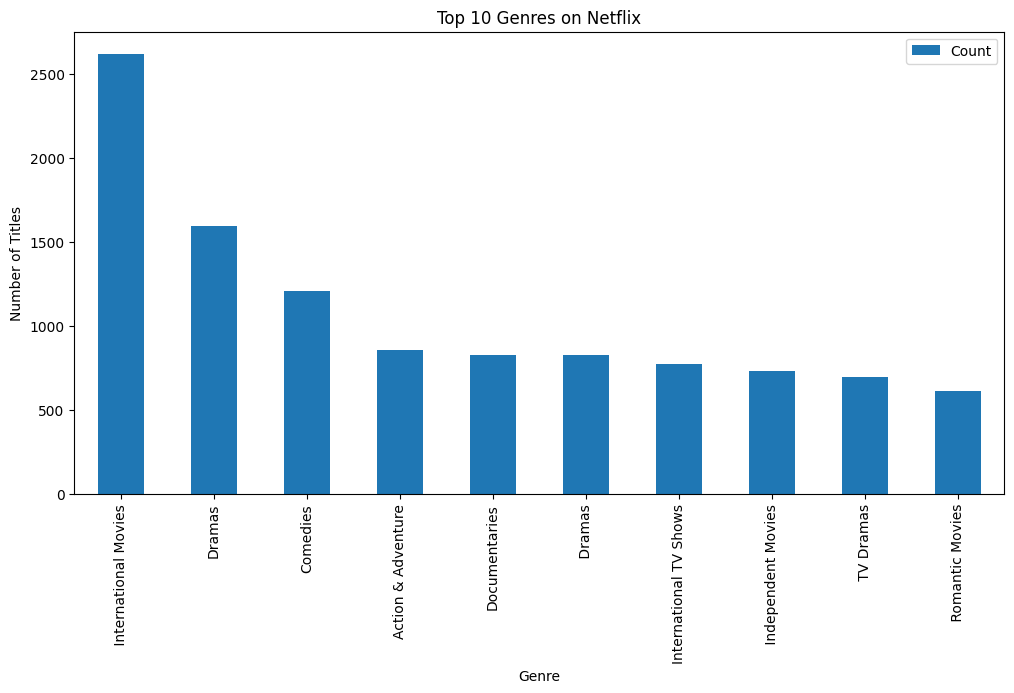

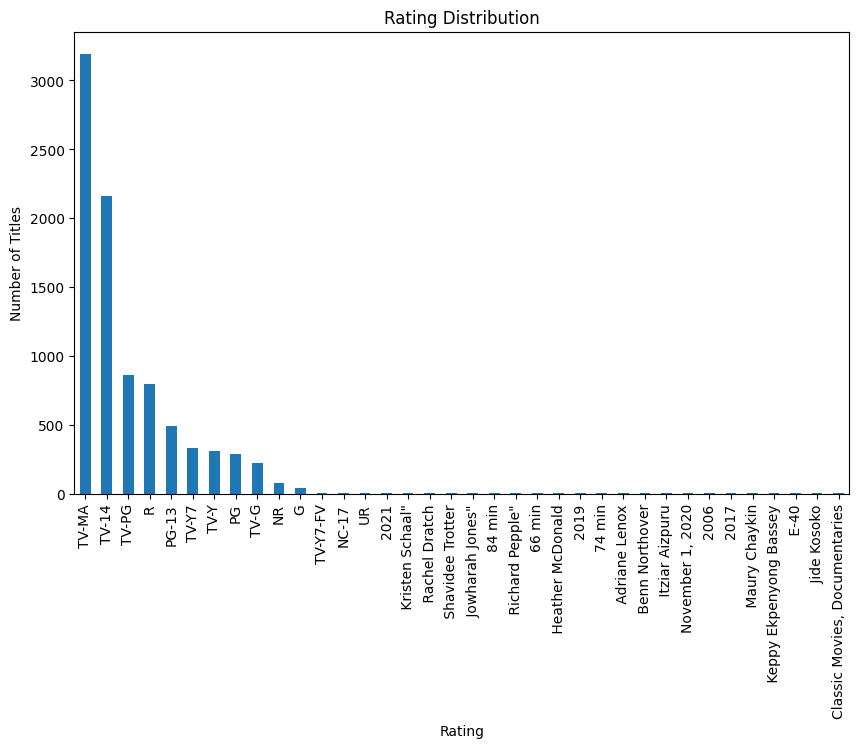

In [19]:

# Plot duration distribution
pandas_df['duration_num'].dropna().hist(bins=30, figsize=(10, 5))
plt.title('Content Duration Distribution')
plt.xlabel('Duration (in minutes or seasons)')
plt.ylabel('Frequency')
plt.show()

# Plot TV Shows vs. Movies distribution
pandas_df['type'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('TV Shows vs. Movies')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

# Plot content added by year
content_by_year = pandas_df.groupby(['added_year', 'type']).size().unstack()
content_by_year.plot(kind='bar', figsize=(15, 7), stacked=True)
plt.title('Content Type Added by Year')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.legend(title='Type')
plt.show()

# Plot content added by month
pandas_df['added_month'] = pandas_df['date_added'].dt.month
content_by_month = pandas_df.groupby(['added_month', 'type']).size().unstack()
content_by_month.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.title('Content Added by Month (TV Shows vs. Movies)')
plt.xlabel('Month')
plt.ylabel('Number of Titles')
plt.legend(title='Type')
plt.show()

# Plot top 10 countries producing content
countries = pandas_df['country'].dropna().str.split(',').sum()
country_counts = Counter(countries)
pd.DataFrame(country_counts.most_common(10), columns=['Country', 'Count']).set_index('Country').plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Countries Producing Content')
plt.xlabel('Country')
plt.ylabel('Number of Titles')
plt.show()

# Plot top 10 genres
genres = pandas_df['listed_in'].dropna().str.split(',').sum()
genre_counts = Counter(genres)
pd.DataFrame(genre_counts.most_common(10), columns=['Genre', 'Count']).set_index('Genre').plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Genres on Netflix')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.show()

# Plot ratings distribution
pandas_df['rating'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Titles')
plt.show()
